In [1]:
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

In [ ]:
My model explains the data discussed in the paper in the following way. It is build on the assumptions that
being prepared or unprepared for a stimulus influences response time. The subject sees a stimulus and tranfers it to
a pulse that represents the human internal clock. This pulse is then transferred back to a time that represents
the guessed time in seconds of which the subject expects a stimulus to appear.
In the lengthened condition the subject is shown 15 trials in which the stimulus is shown 350 ms. In the critical
trial, the 16th trial, the stimulus comes later than expected, at 467 ms. This means that the subject was
ready for seeing the stimulus before it appeared. As a consequence, the maximum reaction time
is shortened by 50 ms. The first graph below shows this, because in the first 15 trials the response time stays around
the same mark, while in the 16th critical trial, in which the stimulus appears later than expected, there
is a 50ms drop in response time. 
In the shortened condition, the stimulus appears at 700 ms in the first 15 trials, so the subject builds up an
expectation that the stimulus will appear around that time. When in the critical trial the stimulus appears earlier
than expected, at 467 ms, the subject is not prepared for it and, as a consequence, the subject needs 50 ms longer
to respond. This is shown in the third graph where we can see that the first 15 trials the response times stay
around the same mark, while in the 16th trial 50 ms is added to the repsonse time. 
In the control group, the stimulus is always shown at 467 ms. We would expect response times to, therefor, stay 
constant. This can be seen in the second graph below. 
I decided to run 150 subject, since this best reproduces the three graphs in the paper. With a smaller amount of
subjects there is much difference of the graphs when re-running the model a couple of times. Any number higher than 150
subjects and nothing much changes when re-running the model. 
The three graphs all start at 410 ms. This makes sense, because a subject has no experience of seeing a stimulus 
and has no expectation of when a stimulus will appear so, therefore, will have the maximum response time of 410 ms.
In all three graphs a hard dip can be seen in the second trial. This also makes sense because they now have seen 
a stimulus appear at a certain moment, so their expectation will be that the next stimulus also appears at that 
moment. In other words, in the second trial subject are prepared and their response times, therefore, will
have a 50ms drop. 
The first few trials in all graphs have a lot of noise. In the paper, the first 5 trials were not plotted in
the graphs. If we were to take out the first 5 trials in these plots, we could see that the graphs are, although
not perfect, a pretty decent fit to those in the paper. The noise coded into the time_to_pulses and pulses_to_time
function influences the fit of the model (although the misfit cannot be fully attributed to this noise)

In [2]:
def noise(s):
    rand = random.uniform(0.001,0.999)
    return s * math.log((1 - rand)/rand)

In [3]:
def time_to_pulses(time, t_0 = 0.011, a = 1.1, b = 0.015, add_noise = True):
    
    pulses = 0
    pulse_duration = t_0
    
    while time >= pulse_duration:
        time = time - pulse_duration
        pulses = pulses + 1
        pulse_duration = a * pulse_duration + add_noise * noise(b * a * pulse_duration)
        
    return pulses

In [4]:
intervals = [0, 0.011, 0.025, 0.1, 0.5, 1, 10]
print("t (s)", "\t", "pulses")
for t in intervals:
    print(t, "\t", time_to_pulses(t))

t (s) 	 pulses
0 	 0
0.011 	 1
0.025 	 2
0.1 	 6
0.5 	 17
1 	 25
10 	 46


In [5]:
def pulses_to_time(pulses, t_0 = 0.011, a = 1.1, b = 0.015, add_noise = True):
    
    time = 0
    pulse_duration = t_0
    
    while pulses > 0:
        time = time + pulse_duration
        pulses = pulses - 1
        pulse_duration = a * pulse_duration + add_noise * noise(b * a * pulse_duration)
    
    return time

In [66]:
def period(time, subs = 150):
    
    #creating empty dataframe of the trial, subject and response to which we will add all information so we can plot
    results = pd.DataFrame(columns = ['trial', 'sub', 'response'])
    
    for sub in range(subs):
        #making an empty list to gather the expectation that is transferred to pulses of the stimulus
        guess = []
           
        #condition lengthened or shortened
        if time == 0.35 or time == 0.7:
            for trial in range(15):
                
                #only in the first trial the response time will be 410 ms, since the subject has no expectation
                #of when the stimulus will appear, so they will take the maximum amount of response time of 410ms.
                if trial==0:
                    results.loc[len(results)] = [trial, sub, 0.41]
                    #skip over the rest of the loop since this only happens in the first trial
                    continue  
                    
                #transfer the time of the stimulus to pulses. This is the 'internal clock' from which 
                #the subject makes a guess    
                pulse_stimulus = time_to_pulses(time)
                
                #add these pulses to the empty list that captures previous experiences from which the subject
                #builds an expectation of when the next stimulus will appear. 
                guess.append(pulse_stimulus)
                
                #take the mean from these expectations to make a guess pulse for the next trial
                guess_pulse = statistics.mean(guess)
                
                #transfer this guess pulse back to time
                time_guess = pulses_to_time(guess_pulse)
                
                #if this expectated time guess is larger than when the actual stimulus appears, response time
                #the subject is unprepared and will have a max response time of 410 ms
                if time_guess > time:
                    response = 0.410
                    
                #if this expectated time guess is smaller than when the actual stimulus appears - 50 ms, 
                #the subject is prepared and their response time will be 50 ms shorter
                if time_guess < time - 0.05:
                    response = 0.410 - 0.05
                    
                #if this expectated time guess in between when the actual stimulus appears - 50 ms and
                #the response time has to be calculated by taking the max response time and withdrawing
                #the time when the stimulus appears - their guess
                if time_guess > time - 0.05 and time_guess < time:
                    response = 0.410 - (time - time_guess) 
                    
                #add the information of the trial, subject and response to the result list so we can plot    
                results.loc[len(results)] = [trial, sub, response]
            
            #the same mechanism works for the critical trial, but here the stimulus appears at 467 ms, which
            #influences whether or not the subject was prepared based on their experiences of seeing the
            #stimulus at 350 ms or at 700 ms
            
            #critical trial
            trial=16
            stimulus_presented = 0.467
            guess_pulse = statistics.mean(guess)
            time_guess = pulses_to_time(guess_pulse)
            if time_guess > stimulus_presented:
                response = 0.410
            if time_guess < stimulus_presented - 0.05:
                response = 0.410 - 0.05
            if time_guess > stimulus_presented - 0.05 and time_guess < stimulus_presented:
                response = 0.410 - (stimulus_presented - time_guess)
                    
            results.loc[len(results)] = [trial, sub, response]


        #condition constant
        if time == 0.467:
            
            #here we don't need to distinguish between normal trials and critical trial, because the stimulus
            #in the constant condition always appears ay 467 ms
            for trial in range(16):
                
                #only in the first trial the response time will be 410 ms, since the subject has no expectation
                #of when the stimulus will appear, so they will take the maximum amount of response time of 410ms.
                if trial==0:
                    results.loc[len(results)] = [trial, sub, 0.41]
                    
                    #skip over the rest of the loop for only the first trial
                    continue           
                 
                #the same mechanism as described above
                pulse_stimulus = time_to_pulses(time)
                guess.append(pulse_stimulus)
                guess_pulse = statistics.mean(guess)
                time_guess = pulses_to_time(guess_pulse)
                stimulus_presented = time
                if time_guess > stimulus_presented:
                    response = 0.410
                if time_guess < stimulus_presented - 0.05:
                    response = 0.410 - 0.05
                if time_guess > stimulus_presented - 0.05 and time_guess < stimulus_presented:
                    response = 0.410 - (stimulus_presented - time_guess)          
                results.loc[len(results)] = [trial, sub, response]
            
     
    #code for plotting trials against response time
    results = results.groupby(['trial'])['response'].mean().reset_index()
    plt.plot(results['trial'], results['response'], marker = "o")
    plt.xlabel("Trial")
    plt.ylabel("Response Time (s)")        

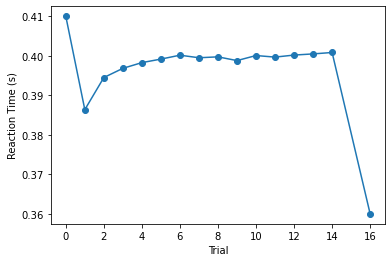

In [67]:
#condition lengthened
period(0.35)

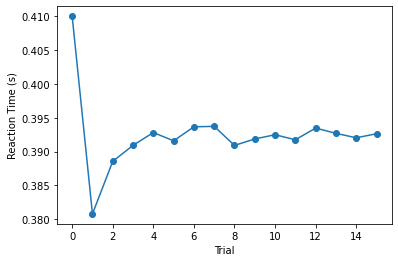

In [68]:
#condition constant
period(0.467)

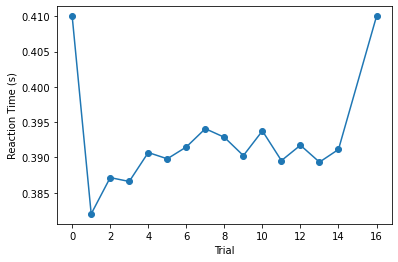

In [69]:
#condition shortened
period(0.7)